# Create resampling of available replicate data to explore effects of noise

In [17]:
import pandas as pd 
import matplotlib.pyplot as plt
import openensembles as oe
import numpy as np

fileName = '../data/experiment.1381.annotated_misTrypsRemoved.txt'
df = pd.read_csv(fileName, sep='\t')

#keep the data and the standard deviations in different dataframes and then instantiate data objects with resampling, 
# ultimately merging them together. 

dataCols  = ['average:data:time(min):0', 'average:data:time(min):1', 'average:data:time(min):2',
       'average:data:time(min):4', 'average:data:time(min):8',
       'average:data:time(min):16', 'average:data:time(min):32']
stdevCols = ['average:stddev:time(min):0', 'average:stddev:time(min):1',
       'average:stddev:time(min):2', 'average:stddev:time(min):4',
       'average:stddev:time(min):8', 'average:stddev:time(min):16',
       'average:stddev:time(min):32']
descriptiveCols = ['gene', 'mod_sites'] #we don't need ALL the metadata, so we'll just start with this

colsToKeep = descriptiveCols + dataCols
master_df = df[colsToKeep]
x = [0, 1, 2, 4, 8, 16, 32]

stdev_df = df[stdevCols]
stdev_df = stdev_df[stdevCols].astype(float)

#This is the data object with data exactly as it stands with means. We'll create
# a list of new data objects that have resampled data representations 
d = oe.data(master_df, x)

In [14]:
#create new data objects, resampling each time point for each object according to their mean and stdev 
# using a normal distribution
numRepeats = 100
d_arr = []
for i in range(0, numRepeats):
    df_temp = master_df.copy()
    #get a series from data and make new data column 
    for index, row in df_temp.iterrows():
        for data in dataCols:
            stdevCol = data.replace('data', 'stddev')
            if stdev_df.ix[index,stdevCol] > 0:
                df_temp.ix[index, data] = np.random.normal(row[data], stdev_df.ix[index,stdevCol])
            else:
                df_temp.ix[index,data] = row[data]
    d_temp = oe.data(df_temp, x)
    d_arr.append(d_temp)



## Perform Majority vote on K-means heuristic to learn a good K

In [20]:
K = 25 
numIterations = 40
c_MV_arr = []
fig_arr = []
modulo = 1 #if you want to calculate majority vote only ever other or few solutions, increase this number
sil_arr = []
det_arr = []
num_clusters = []

c = oe.cluster(d) 

for i in range(1,numIterations):
    name = 'kmeans_' + str(i)
    c.cluster('parent', 'kmeans', name, K, init = 'random', n_init = 1)
    if not i % modulo:
        x = c.finish_majority_vote(threshold=0.5)
        c_MV_arr.append(x)
        num_clusters.append(len(x.clusterNumbers['majority_vote']))
        v = oe.validation(d, x)
        
        #A compactness metric
        validation_name = 'silhouette'
        v.calculate(validation_name, 'majority_vote', 'parent')
        name = validation_name+'_parent_majority_vote'
        sil_arr.append(v.validation[name])

        #A metric for connectedness
        validation_name = 'det_ratio'
        v.calculate(validation_name, 'majority_vote', 'parent')

/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/knaegle/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/knaegle/GIT/public/OpenEnsembles/openensembles/validation.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  self.validation = np.linalg.det(t)/np.linalg.det(wg)


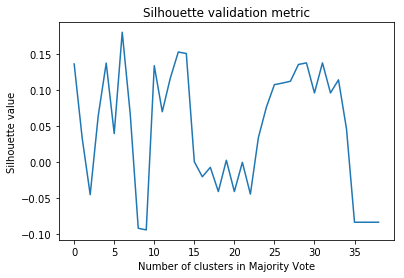

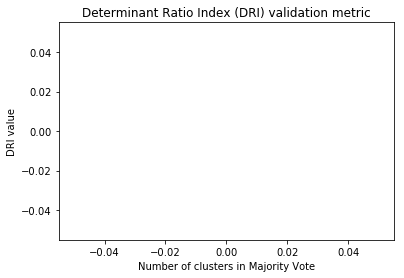

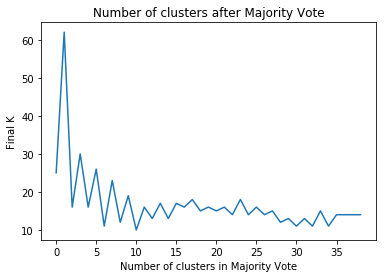

In [21]:
#Compactness
plt.plot(sil_arr)
plt.title('Silhouette validation metric')
plt.xlabel('Number of clusters in Majority Vote')
plt.ylabel('Silhouette value')
plt.show()

#Connectedness
plt.plot(det_arr)
plt.title('Determinant Ratio Index (DRI) validation metric')
plt.xlabel('Number of clusters in Majority Vote')
plt.ylabel('DRI value')
plt.show()

#Convergence towards final K
plt.plot(num_clusters)
plt.xlabel('Number of clusters in Majority Vote')
plt.ylabel('Final K')
plt.title('Number of clusters after Majority Vote')
plt.show()

## Cluster all resampled data for an ensemble solution

In [ ]:
transdict = d.merge(d_arr) #merge all data matrices together (could also just iterate through )

In [ ]:
K = 

for name in d.D.keys():
    
    